# Refer to SF EDA notebook for Price EDA (Section 5 & 10)

# Import Libraries

In [176]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Import Data

In [177]:
SF_df = pd.read_pickle("pre-processing and EDA/cleaned_price_df.pkl")
SF_df.head(5)

,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,property_type,room_type,accommodates,bathrooms,bedrooms,beds,amenities,price,minimum_nights,maximum_nights,number_of_reviews,review_scores_rating,reviews_per_month,price_log
0,within an hour,1.0,0.99,1,1,Western Addition,Entire apartment,Entire home/apt,3,1.0,1.0,2.0,"[""Heating"", ""Hot water"", ""Stove"", ""Iron"", ""Dry...",132.0,2,30,257,97.0,1.91,4.882802
1,within a day,0.6,0.83,0,2,Bernal Heights,Entire apartment,Entire home/apt,5,1.0,2.0,3.0,"[""Smoke alarm"", ""Heating"", ""Kitchen"", ""First a...",235.0,30,60,111,98.0,0.81,5.459586
2,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,60,19,84.0,0.14,4.025352
3,within a few hours,1.0,1.00,0,10,Haight Ashbury,Private room in apartment,Private room,2,4.0,1.0,1.0,"[""Host greets you"", ""Heating"", ""Hot water"", ""K...",56.0,32,90,8,93.0,0.11,4.025352
5,within an hour,1.0,0.96,1,2,Mission,Private room in condominium,Private room,3,1.0,1.0,1.0,"[""Heating"", ""Hot water"", ""Children\u2019s book...",169.0,1,14,736,98.0,5.47,5.129899


In [178]:
SF_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 7273
Data columns (total 20 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6848 non-null   object 
 1   host_response_rate      6848 non-null   float64
 2   host_acceptance_rate    6848 non-null   float64
 3   host_is_superhost       6848 non-null   int32  
 4   host_listings_count     6848 non-null   int64  
 5   neighbourhood_cleansed  6848 non-null   object 
 6   property_type           6848 non-null   object 
 7   room_type               6848 non-null   object 
 8   accommodates            6848 non-null   int64  
 9   bathrooms               6848 non-null   float64
 10  bedrooms                6848 non-null   float64
 11  beds                    6848 non-null   float64
 12  amenities               6848 non-null   object 
 13  price                   6848 non-null   float64
 14  minimum_nights          6848 non-null   

# Different column type name lists

In [179]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = SF_df.select_dtypes(include=numerics).columns.to_list()
bool_columns = SF_df.select_dtypes(include='bool').columns.to_list()
object_columns = SF_df.select_dtypes(include='object').columns.to_list()
print(object_columns)

['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']


In [180]:
SF_df.isnull().sum()

host_response_time        0
host_response_rate        0
host_acceptance_rate      0
host_is_superhost         0
host_listings_count       0
neighbourhood_cleansed    0
property_type             0
room_type                 0
accommodates              0
bathrooms                 0
bedrooms                  0
beds                      0
amenities                 0
price                     0
minimum_nights            0
maximum_nights            0
number_of_reviews         0
review_scores_rating      0
reviews_per_month         0
price_log                 0
dtype: int64

# Pearson Correlation for Numeric Columns

In [181]:
#sns.set(style="ticks", color_codes=True)
#sns.pairplot(SF_df[numeric_columns])

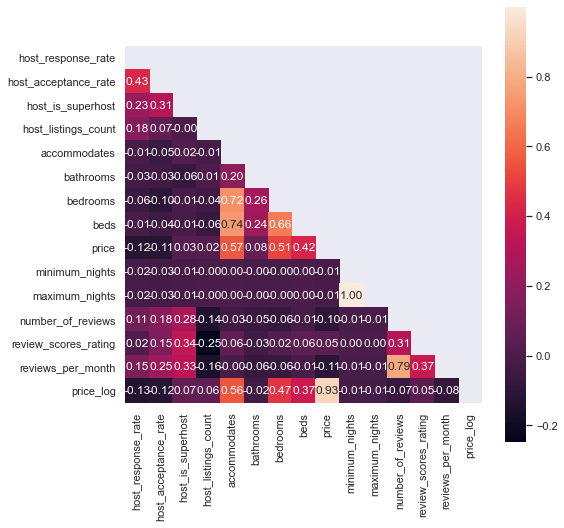

In [182]:
corr = SF_df[numeric_columns].corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
plt.figure(figsize = (8,8))
sns.set(font_scale=1)
sns.heatmap(corr, cbar = True, annot=True, square = True, fmt = '.2f', xticklabels=numeric_columns, yticklabels=numeric_columns, mask=mask)

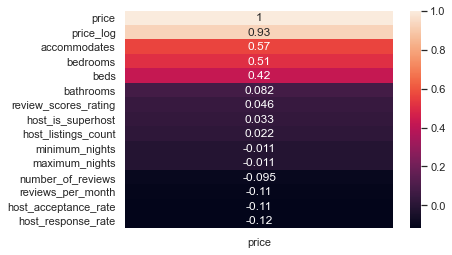

In [183]:
sns.heatmap(corr[['price']].sort_values(['price'],ascending=False),yticklabels=True,annot=True)

In [184]:
SF_df["host_is_superhost"]

0       1
1       0
2       0
3       0
5       1
       ..
7269    0
7270    0
7271    0
7272    0
7273    1
Name: host_is_superhost, Length: 6848, dtype: int32

# Feature Selection

## Remove features based on Pearson Correlation

In [185]:
new_SF_df = SF_df.drop(columns=['bedrooms','beds','maximum_nights','number_of_reviews'])

In [186]:
print(new_SF_df.columns)

Index(['host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_listings_count', 'neighbourhood_cleansed',
       'property_type', 'room_type', 'accommodates', 'bathrooms', 'amenities',
       'price', 'minimum_nights', 'review_scores_rating', 'reviews_per_month',
       'price_log'],
      dtype='object')


## Remove based on p-values (Backward Elimination)

In [187]:
import statsmodels.api as sm

y = SF_df['price']
X = SF_df[numeric_columns].drop(['price','price_log'], axis =1)

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues.to_frame().reset_index().rename(columns={'index': 'feature', 0: 'p-value'}).sort_values(by='p-value', ascending=False)

,feature,p-value
11,number_of_reviews,7.198979e-01
9,minimum_nights,8.481813e-02
10,maximum_nights,8.471748e-02
8,beds,1.714166e-02
2,host_acceptance_rate,5.174953e-04
12,review_scores_rating,2.732478e-05
4,host_listings_count,6.411037e-07
6,bathrooms,6.969503e-09
3,host_is_superhost,3.032647e-11
13,reviews_per_month,1.800328e-12


In [188]:
#Backward Elimination
cols = list(X.columns)
removed_features_BE = []
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05): # remove if p-value > 0.05
        cols.remove(feature_with_p_max)
        removed_features_BE.append(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(f"Selected Features: {len(selected_features_BE)}")
print(selected_features_BE)
print(f"Removed Features: {len(removed_features_BE)}")
print(removed_features_BE)

Selected Features: 10
['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'accommodates', 'bathrooms', 'bedrooms', 'beds', 'review_scores_rating', 'reviews_per_month']
Removed Features: 3
['number_of_reviews', 'minimum_nights', 'maximum_nights']


## Skipped Removal by Backward Elimination because removing more gives worse performance

In [189]:
# for feature in removed_features_BE:
#     if feature in new_SF_df.columns:
#         new_SF_df.drop(columns=[feature],inplace=True)
# print(new_SF_df.columns)
# print(len(new_SF_df.columns))

In [190]:
new_SF_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6848 entries, 0 to 7273
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   host_response_time      6848 non-null   object 
 1   host_response_rate      6848 non-null   float64
 2   host_acceptance_rate    6848 non-null   float64
 3   host_is_superhost       6848 non-null   int32  
 4   host_listings_count     6848 non-null   int64  
 5   neighbourhood_cleansed  6848 non-null   object 
 6   property_type           6848 non-null   object 
 7   room_type               6848 non-null   object 
 8   accommodates            6848 non-null   int64  
 9   bathrooms               6848 non-null   float64
 10  amenities               6848 non-null   object 
 11  price                   6848 non-null   float64
 12  minimum_nights          6848 non-null   int64  
 13  review_scores_rating    6848 non-null   float64
 14  reviews_per_month       6848 non-null   

In [191]:
new_SF_df_copy = new_SF_df

# Reassign column types

In [192]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
numeric_columns = new_SF_df.select_dtypes(include=numerics).columns.to_list()
bool_columns = new_SF_df.select_dtypes(include='bool').columns.to_list()
object_columns = new_SF_df.select_dtypes(include='object').columns.to_list()
print(object_columns)

['host_response_time', 'neighbourhood_cleansed', 'property_type', 'room_type', 'amenities']


# Data Pre-processing for non-numeric columns

## Converting bool to numeric

In [193]:
for column in bool_columns:
    SF_df[column] = SF_df[column].replace(False,0,regex=True)
    SF_df[column] = SF_df[column].replace(True,1,regex=True)
SF_df["host_is_superhost"].head()

0    1
1    0
2    0
3    0
5    1
Name: host_is_superhost, dtype: int32

## Transforming amenities to numeric columns

In [194]:
SF_df.amenities = SF_df.amenities.str.replace('"', "")
SF_df.amenities = SF_df.amenities.str.replace("[", "")
SF_df.amenities = SF_df.amenities.str.replace("]", "")
SF_df['amenities'].head()

0    Heating, Hot water, Stove, Iron, Dryer, Coffee...
1    Smoke alarm, Heating, Kitchen, First aid kit, ...
2    Host greets you, Heating, Hot water, Kitchen, ...
3    Host greets you, Heating, Hot water, Kitchen, ...
5    Heating, Hot water, Children\u2019s books and ...
Name: amenities, dtype: object

In [195]:
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer =  CountVectorizer(tokenizer=lambda x: x.split(', '))
amenities = count_vectorizer.fit_transform(SF_df['amenities'])
df_amenities = pd.DataFrame(amenities.toarray(), columns=count_vectorizer.get_feature_names())
df_amenities = df_amenities.drop('',1)

In [196]:
len(df_amenities.columns.to_list())

115

In [197]:
df_amenities.columns.to_list()

['air conditioning',
 'alarm system',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'baking sheet',
 'barbecue utensils',
 'bathroom essentials',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bread maker',
 'breakfast',
 'breakfast bar',
 'building staff',
 'cable tv',
 'carbon monoxide alarm',
 'changing table',
 'children\\u2019s books and toys',
 'children\\u2019s dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'cooking basics',
 'crib',
 'desk',
 'dishes and silverware',
 'dishwasher',
 'dryer',
 'dual vanity',
 'elevator',
 'essentials',
 'ethernet connection',
 'ev charger',
 'extra pillows and blankets',
 'fire extinguisher',
 'fireplace guards',
 'first aid kit',
 'free parking on premises',
 'free street parking',
 'full kitchen',
 'game console',
 'garden or backyard',
 'gas fireplace',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'high chair',
 'host greets you',
 'hot tub',
 'hot water',
 

In [198]:
listings_new = SF_df[numeric_columns+bool_columns]
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,price,minimum_nights,review_scores_rating,reviews_per_month,price_log
0,1.0,0.99,1,1,3,1.0,132.0,2,97.0,1.91,4.882802
1,0.6,0.83,0,2,5,1.0,235.0,30,98.0,0.81,5.459586
2,1.0,1.00,0,10,2,4.0,56.0,32,84.0,0.14,4.025352
3,1.0,1.00,0,10,2,4.0,56.0,32,93.0,0.11,4.025352
5,1.0,0.96,1,2,3,1.0,169.0,1,98.0,5.47,5.129899


## Transforming categorical columns to numeric columns and creating new df

In [199]:
for categorical_col in object_columns[:-1]:
    listings_new = pd.concat([listings_new, pd.get_dummies(SF_df[categorical_col])], axis=1)

In [200]:
#listings_new.columns.to_list()
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,price,minimum_nights,review_scores_rating,reviews_per_month,...,Shared room in hostel,Shared room in house,Shared room in loft,Shared room in townhouse,Shared room in villa,Tiny house,Entire home/apt,Hotel room,Private room,Shared room
0,1.0,0.99,1,1,3,1.0,132.0,2,97.0,1.91,...,0,0,0,0,0,0,1,0,0,0
1,0.6,0.83,0,2,5,1.0,235.0,30,98.0,0.81,...,0,0,0,0,0,0,1,0,0,0
2,1.0,1.00,0,10,2,4.0,56.0,32,84.0,0.14,...,0,0,0,0,0,0,0,0,1,0
3,1.0,1.00,0,10,2,4.0,56.0,32,93.0,0.11,...,0,0,0,0,0,0,0,0,1,0
5,1.0,0.96,1,2,3,1.0,169.0,1,98.0,5.47,...,0,0,0,0,0,0,0,0,1,0


In [201]:
listings_new = pd.concat([listings_new, df_amenities], axis=1, join='inner')
listings_new.head()

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,price,minimum_nights,review_scores_rating,reviews_per_month,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,1.0,0.99,1,1,3,1.0,132.0,2,97.0,1.91,...,0,0,1,0,1,0,0,1,0,0
1,0.6,0.83,0,2,5,1.0,235.0,30,98.0,0.81,...,0,0,0,0,1,0,0,1,0,0
2,1.0,1.00,0,10,2,4.0,56.0,32,84.0,0.14,...,0,0,1,0,1,0,0,1,0,0
3,1.0,1.00,0,10,2,4.0,56.0,32,93.0,0.11,...,0,0,1,0,1,0,0,1,0,0
5,1.0,0.96,1,2,3,1.0,169.0,1,98.0,5.47,...,0,0,1,0,1,0,0,1,0,0


In [202]:
listings_new.columns.to_list()
# listings_new.columns.duplicated()

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'price',
 'minimum_nights',
 'review_scores_rating',
 'reviews_per_month',
 'price_log',
 '-',
 'a few days or more',
 'within a day',
 'within a few hours',
 'within an hour',
 'Bayview',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Crocker Amazon',
 'Diamond Heights',
 'Downtown/Civic Center',
 'Excelsior',
 'Financial District',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Inner Richmond',
 'Inner Sunset',
 'Lakeshore',
 'Marina',
 'Mission',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Ocean View',
 'Outer Mission',
 'Outer Richmond',
 'Outer Sunset',
 'Pacific Heights',
 'Parkside',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Treasure Island/YBI',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Western Addition',
 'Boat',
 'Casa particular',
 'Earth house',
 '

## Check for Duplicates

In [203]:
if listings_new.duplicated().any():
    duplicate_rows = listings_new[listings_new.duplicated()]
    print("Duplicates Removed")
print(listings_new.duplicated().any())

False


In [204]:
# rename duplicate column
listings_new.columns = \
['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'price',
 'minimum_nights',
 'review_scores_rating',
 'reviews_per_month',
 'price_log',
 '-',
 'a few days or more',
 'within a day',
 'within a few hours',
 'within an hour',
 'Bayview',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Crocker Amazon',
 'Diamond Heights',
 'Downtown/Civic Center',
 'Excelsior',
 'Financial District',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Inner Richmond',
 'Inner Sunset',
 'Lakeshore',
 'Marina',
 'Mission',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Ocean View',
 'Outer Mission',
 'Outer Richmond',
 'Outer Sunset',
 'Pacific Heights',
 'Parkside',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Treasure Island/YBI',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Western Addition',
 'Boat',
 'Casa particular',
 'Earth house',
 'Entire apartment',
 'Entire bungalow',
 'Entire cabin',
 'Entire condominium',
 'Entire cottage',
 'Entire floor',
 'Entire guest suite',
 'Entire guesthouse',
 'Entire house',
 'Entire in-law',
 'Entire loft',
 'Entire place',
 'Entire serviced apartment',
 'Entire townhouse',
 'Entire villa',
 'Private room (Property Type)',
 'Private room in apartment',
 'Private room in bed and breakfast',
 'Private room in bungalow',
 'Private room in cabin',
 'Private room in castle',
 'Private room in condominium',
 'Private room in cottage',
 'Private room in earth house',
 'Private room in guest suite',
 'Private room in guesthouse',
 'Private room in hostel',
 'Private room in house',
 'Private room in hut',
 'Private room in loft',
 'Private room in resort',
 'Private room in serviced apartment',
 'Private room in townhouse',
 'Private room in villa',
 'Room in aparthotel',
 'Room in bed and breakfast',
 'Room in boutique hotel',
 'Room in hostel',
 'Room in hotel',
 'Room in serviced apartment',
 'Shared room in apartment',
 'Shared room in bed and breakfast',
 'Shared room in boutique hotel',
 'Shared room in bungalow',
 'Shared room in condominium',
 'Shared room in hostel',
 'Shared room in house',
 'Shared room in loft',
 'Shared room in townhouse',
 'Shared room in villa',
 'Tiny house',
 'Entire home/apt',
 'Hotel room',
 'Private room',
 'Shared room',
 'air conditioning',
 'alarm system',
 'baby bath',
 'baby monitor',
 'babysitter recommendations',
 'baking sheet',
 'barbecue utensils',
 'bathroom essentials',
 'bathtub',
 'bbq grill',
 'beach essentials',
 'beachfront',
 'bed linens',
 'bedroom comforts',
 'bread maker',
 'breakfast',
 'breakfast bar',
 'building staff',
 'cable tv',
 'carbon monoxide alarm',
 'changing table',
 'children\\u2019s books and toys',
 'children\\u2019s dinnerware',
 'cleaning before checkout',
 'coffee maker',
 'cooking basics',
 'crib',
 'desk',
 'dishes and silverware',
 'dishwasher',
 'dryer',
 'dual vanity',
 'elevator',
 'essentials',
 'ethernet connection',
 'ev charger',
 'extra pillows and blankets',
 'fire extinguisher',
 'fireplace guards',
 'first aid kit',
 'free parking on premises',
 'free street parking',
 'full kitchen',
 'game console',
 'garden or backyard',
 'gas fireplace',
 'gym',
 'hair dryer',
 'hangers',
 'heating',
 'high chair',
 'host greets you',
 'hot tub',
 'hot water',
 'indoor fireplace',
 'iron',
 'ironing board',
 'jetted tub',
 'keypad',
 'kitchen',
 'kitchenette',
 'lake access',
 'laptop-friendly workspace',
 'lock on bedroom door',
 'lockbox',
 'long term stays allowed',
 'luggage dropoff allowed',
 'microwave',
 'mini fridge',
 'natural gas barbeque',
 'office',
 'outlet covers',
 'oven',
 'pack \\u2019n play/travel crib',
 'paid parking off premises',
 'paid parking on premises',
 'patio or balcony',
 'pets allowed',
 'piano',
 'pocket wifi',
 'pool',
 'portable air conditioning',
 'private entrance',
 'private hot tub',
 'private living room',
 'refrigerator',
 'room-darkening shades',
 'security cameras',
 'self check-in',
 'shampoo',
 'shared hot tub',
 'shower gel',
 'single level home',
 'ski-in/ski-out',
 'smart home technology',
 'smart lock',
 'smart tv',
 'smoke alarm',
 'smoking allowed',
 'sonos sound system',
 'stair gates',
 'stand alone bathtub',
 'stand alone rain shower',
 'stove',
 'suitable for events',
 'table corner guards',
 'terrace',
 'tv',
 'walk in closet',
 'washer',
 'waterfront',
 'wet bar',
 'wifi',
 'window guards',
 'wine cooler']

In [205]:
listings_new.drop(columns=['-'],inplace=True)

In [206]:
listings_new.columns.to_list()

['host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_listings_count',
 'accommodates',
 'bathrooms',
 'price',
 'minimum_nights',
 'review_scores_rating',
 'reviews_per_month',
 'price_log',
 'a few days or more',
 'within a day',
 'within a few hours',
 'within an hour',
 'Bayview',
 'Bernal Heights',
 'Castro/Upper Market',
 'Chinatown',
 'Crocker Amazon',
 'Diamond Heights',
 'Downtown/Civic Center',
 'Excelsior',
 'Financial District',
 'Glen Park',
 'Golden Gate Park',
 'Haight Ashbury',
 'Inner Richmond',
 'Inner Sunset',
 'Lakeshore',
 'Marina',
 'Mission',
 'Nob Hill',
 'Noe Valley',
 'North Beach',
 'Ocean View',
 'Outer Mission',
 'Outer Richmond',
 'Outer Sunset',
 'Pacific Heights',
 'Parkside',
 'Potrero Hill',
 'Presidio',
 'Presidio Heights',
 'Russian Hill',
 'Seacliff',
 'South of Market',
 'Treasure Island/YBI',
 'Twin Peaks',
 'Visitacion Valley',
 'West of Twin Peaks',
 'Western Addition',
 'Boat',
 'Casa particular',
 'Earth house',
 'Entire

In [207]:
listings_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6465 entries, 0 to 6847
Columns: 225 entries, host_response_rate to wine cooler
dtypes: float64(7), int32(1), int64(118), uint8(99)
memory usage: 6.8 MB


# Feature Selection by Backward Elimination

## Remove based on p-values (Backward Elimination)

In [208]:
import statsmodels.api as sm

y = listings_new['price']
X = listings_new.drop(['price','price_log'], axis =1)

#Adding constant column of ones, mandatory for sm.OLS model
X_1 = sm.add_constant(X)
#Fitting sm.OLS model
model = sm.OLS(y,X_1).fit()
model.pvalues.to_frame().reset_index().rename(columns={'index': 'feature', 0: 'p-value'}).sort_values(by='p-value', ascending=False)

,feature,p-value
181,oven,9.953758e-01
119,beach essentials,9.809498e-01
148,first aid kit,9.604903e-01
189,pool,9.545118e-01
41,Presidio,9.536734e-01
...,...,...
12,within a few hours,1.258840e-12
0,const,3.691704e-13
14,Bayview,3.027847e-13
3,host_is_superhost,1.073387e-13


In [209]:
#Backward Elimination
cols = list(X.columns)
removed_features_BE = []
pmax = 1
while (len(cols)>0):
    p= []
    X_1 = X[cols]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y,X_1).fit()
    p = pd.Series(model.pvalues.values[1:],index = cols)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax>0.05): # remove if p-value > 0.05
        cols.remove(feature_with_p_max)
        removed_features_BE.append(feature_with_p_max)
    else:
        break
selected_features_BE = cols
print(f"Selected Features: {len(selected_features_BE)}")
print(selected_features_BE)
print(f"Removed Features: {len(removed_features_BE)}")
print(removed_features_BE)

Selected Features: 60
['host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_listings_count', 'accommodates', 'bathrooms', 'reviews_per_month', 'a few days or more', 'within a day', 'within a few hours', 'within an hour', 'Bayview', 'Bernal Heights', 'Castro/Upper Market', 'Chinatown', 'Crocker Amazon', 'Excelsior', 'Financial District', 'Lakeshore', 'Marina', 'Noe Valley', 'North Beach', 'Ocean View', 'Outer Mission', 'Outer Sunset', 'Pacific Heights', 'Parkside', 'Potrero Hill', 'Russian Hill', 'South of Market', 'Visitacion Valley', 'West of Twin Peaks', 'Earth house', 'Entire apartment', 'Entire bungalow', 'Entire guest suite', 'Entire guesthouse', 'Entire house', 'Entire serviced apartment', 'Entire villa', 'Private room in apartment', 'Room in boutique hotel', 'Room in hotel', 'Room in serviced apartment', 'Shared room in bed and breakfast', 'Entire home/apt', 'Hotel room', 'Private room', 'Shared room', 'bread maker', 'children\\u2019s dinnerware', 'dishwasher

## Skipped Removal by Backward Elimination because removing more gives worse performance

In [210]:
# for feature in removed_features_BE:
#     if feature in listings_new.columns:
#         listings_new.drop(columns=[feature],inplace=True)
# print(listings_new.columns)
# print(len(listings_new.columns))

In [211]:
# listings_new.to_pickle('listings_for_analysis.pkl')


# pickle_listings_new_df = pd.read_pickle('listings_for_analysis.pkl')
# pickle_listings_new_df.head(5)

# Train/Test split

In [212]:
from sklearn.model_selection import train_test_split
y = listings_new['price'] # target/dependent variable
x = listings_new.drop(['price','price_log'], axis =1) # independent variables

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

# Random Forest

## Train/Test w Random Forest Algorithm

In [213]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3, 
                               n_jobs=-1)
rf.fit(X_train, y_train)
y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 73.237
R^2 test: 0.542


## Feature Importance of Random Forest Algorithm

In [214]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = rf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
4,accommodates,0.296000
8,reviews_per_month,0.083542
5,bathrooms,0.078225
6,minimum_nights,0.074518
3,host_listings_count,0.049112
104,Entire home/apt,0.037821
1,host_acceptance_rate,0.022282
7,review_scores_rating,0.020789
0,host_response_rate,0.020337
56,Entire condominium,0.007551


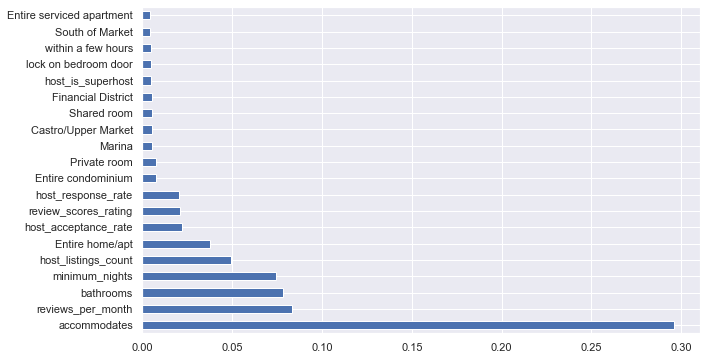

In [215]:
feat_imp = pd.Series(rf.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

# LightGBM

## Train/Test w LightGBM

In [216]:
from lightgbm import LGBMRegressor

fit_params={
    "early_stopping_rounds":20, 
            "eval_metric" : 'rmse', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100,
            'feature_name': 'auto', 
            'categorical_feature': 'auto'
           }
        
class LGBMRegressor_GainFE(LGBMRegressor):
    @property
    def feature_importances_(self):
        if self._n_features is None:
            raise LGBMNotFittedError('No feature_importances found. Need to call fit beforehand.')
        return self.booster_.feature_importance(importance_type='gain')
        
clf = LGBMRegressor_GainFE(num_leaves= 25, max_depth=20, 
                         random_state=0, 
                         silent=True, 
                         metric='rmse', 
                         n_jobs=4, 
                         n_estimators=1000,
                         colsample_bytree=0.9,
                         subsample=0.9,
                         learning_rate=0.01)
clf.fit(X_train.values, y_train.values, **fit_params)
y_pred = clf.predict(X_test.values)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

Training until validation scores don't improve for 20 rounds
[100]	valid's rmse: 80.6886
[200]	valid's rmse: 74.1858
[300]	valid's rmse: 71.6825
[400]	valid's rmse: 70.0988
[500]	valid's rmse: 69.4311
[600]	valid's rmse: 69.1035
[700]	valid's rmse: 68.9728
Early stopping, best iteration is:
[770]	valid's rmse: 68.881
R^2 test: 0.595


## Feature Importance of LightGBM

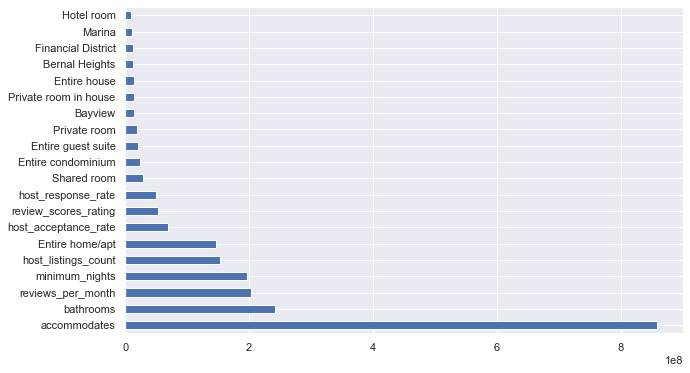

In [217]:
feat_imp = pd.Series(clf.feature_importances_, index=x.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

In [218]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = x.columns
coefs_df['coefs'] = clf.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
4,accommodates,8.574521e+08
5,bathrooms,2.417205e+08
8,reviews_per_month,2.033222e+08
6,minimum_nights,1.963532e+08
3,host_listings_count,1.524354e+08
104,Entire home/apt,1.467364e+08
1,host_acceptance_rate,6.830052e+07
7,review_scores_rating,5.337678e+07
0,host_response_rate,4.982944e+07
107,Shared room,2.891114e+07


# Gradient Boosting

## Train/Test w Gradient Boosting

In [219]:
from sklearn.ensemble import GradientBoostingRegressor


gboost = GradientBoostingRegressor(n_estimators=500, 
                               criterion='mse', 
                               random_state=3)
gboost.fit(X_train, y_train)
y_train_pred = gboost.predict(X_train)
y_test_pred = gboost.predict(X_test)
rmse_rf= (mean_squared_error(y_test,y_test_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_test_pred)))

RMSE test: 71.068
R^2 test: 0.569


## Feature Importance of Gradient Boosting

In [220]:
coefs_df = pd.DataFrame()
coefs_df['feature'] = X_train.columns
coefs_df['coefs'] = gboost.feature_importances_
coefs_df.sort_values('coefs', ascending=False).head(20)

,feature,coefs
4,accommodates,0.386151
6,minimum_nights,0.096947
5,bathrooms,0.085413
3,host_listings_count,0.056265
104,Entire home/apt,0.053065
8,reviews_per_month,0.050773
0,host_response_rate,0.025150
7,review_scores_rating,0.021718
1,host_acceptance_rate,0.018226
56,Entire condominium,0.013565


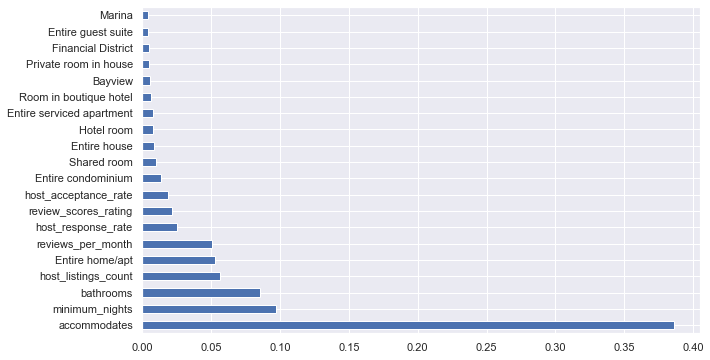

In [221]:
feat_imp = pd.Series(gboost.feature_importances_, index=X_train.columns)
feat_imp.nlargest(20).plot(kind='barh', figsize=(10,6))

# XGBoost and its Feature Importance


Training MSE: 975.2514
Validation MSE: 5332.4916
Validation RMSE: 73.0239

Training r2: 0.9243
Validation r2: 0.5448


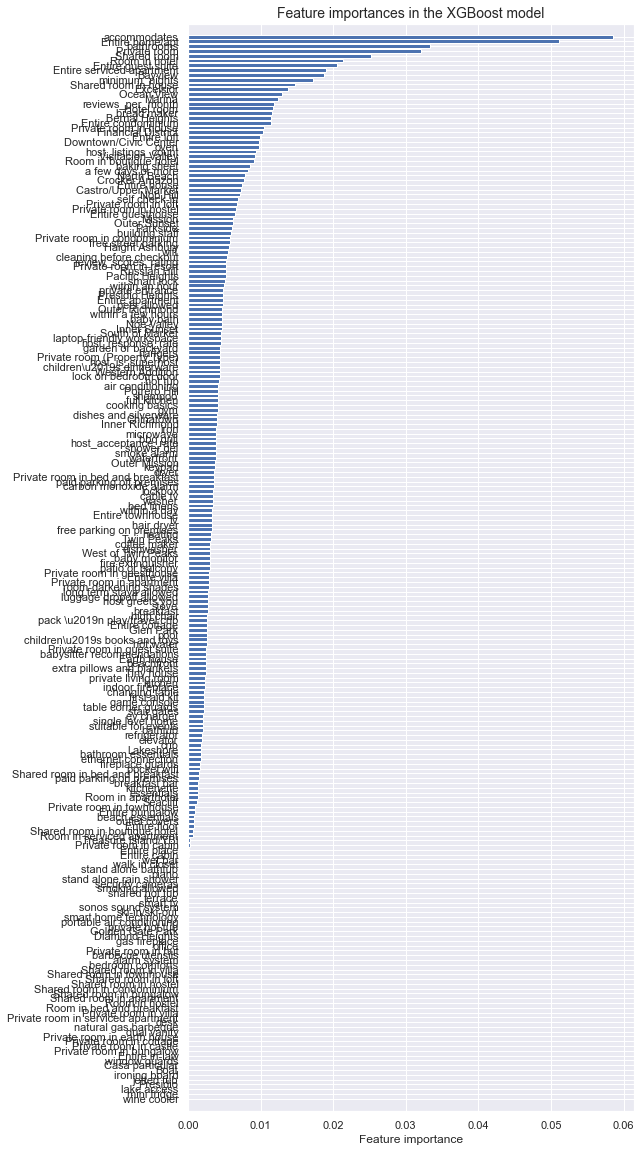

In [222]:
import xgboost as xgb

# Fitting the model
xgb_reg = xgb.XGBRegressor()
xgb_reg.fit(X_train, y_train)
training_preds_xgb_reg = xgb_reg.predict(X_train)
val_preds_xgb_reg = xgb_reg.predict(X_test)

# Printing the results

print("\nTraining MSE:", round(mean_squared_error(y_train, training_preds_xgb_reg),4))
print("Validation MSE:", round(mean_squared_error(y_test, val_preds_xgb_reg),4))
print("Validation RMSE:", round(mean_squared_error(y_test, val_preds_xgb_reg)**0.5,4))
print("\nTraining r2:", round(r2_score(y_train, training_preds_xgb_reg),4))
print("Validation r2:", round(r2_score(y_test, val_preds_xgb_reg),4))

# Producing a dataframe of feature importances
ft_weights_xgb_reg = pd.DataFrame(xgb_reg.feature_importances_, columns=['weight'], index=X_train.columns)
ft_weights_xgb_reg.sort_values('weight', inplace=True)

# Plotting feature importances
plt.figure(figsize=(8,20))
plt.barh(ft_weights_xgb_reg.index, ft_weights_xgb_reg.weight, align='center') 
plt.title("Feature importances in the XGBoost model", fontsize=14)
plt.xlabel("Feature importance")
plt.margins(y=0.01)
plt.show()

# Neural Network Model

In [223]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(512, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Printing the model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

# Training the model
nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 128)               28672     
_________________________________________________________________
dense_21 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_22 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_23 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 513       
Total params: 259,585
Trainable params: 259,585
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
18/18 [==============================] - 0s 24ms/step - loss: 24395.5215 - mean_squared_error: 24

Epoch 42/100
18/18 [==============================] - 0s 11ms/step - loss: 4637.7827 - mean_squared_error: 4637.7827 - val_loss: 6594.9907 - val_mean_squared_error: 6594.9907
Epoch 43/100
18/18 [==============================] - 0s 11ms/step - loss: 5075.4512 - mean_squared_error: 5075.4512 - val_loss: 6115.1138 - val_mean_squared_error: 6115.1138
Epoch 44/100
18/18 [==============================] - 0s 12ms/step - loss: 4752.5122 - mean_squared_error: 4752.5122 - val_loss: 5797.9404 - val_mean_squared_error: 5797.9404
Epoch 45/100
18/18 [==============================] - 0s 16ms/step - loss: 4584.1519 - mean_squared_error: 4584.1519 - val_loss: 5901.7827 - val_mean_squared_error: 5901.7827
Epoch 46/100
18/18 [==============================] - 0s 10ms/step - loss: 4704.5723 - mean_squared_error: 4704.5723 - val_loss: 5340.2578 - val_mean_squared_error: 5340.2578
Epoch 47/100
18/18 [==============================] - 0s 10ms/step - loss: 4522.6978 - mean_squared_error: 4522.6978 - val_lo

Epoch 89/100
18/18 [==============================] - 0s 10ms/step - loss: 3831.5193 - mean_squared_error: 3831.5193 - val_loss: 5272.8599 - val_mean_squared_error: 5272.8599
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 3551.5913 - mean_squared_error: 3551.5913 - val_loss: 5205.9917 - val_mean_squared_error: 5205.9917
Epoch 91/100
18/18 [==============================] - 0s 9ms/step - loss: 3689.0139 - mean_squared_error: 3689.0139 - val_loss: 5687.7485 - val_mean_squared_error: 5687.7485
Epoch 92/100
18/18 [==============================] - 0s 14ms/step - loss: 4149.7246 - mean_squared_error: 4149.7246 - val_loss: 5345.2969 - val_mean_squared_error: 5345.2969
Epoch 93/100
18/18 [==============================] - 0s 10ms/step - loss: 3816.8215 - mean_squared_error: 3816.8215 - val_loss: 7931.1235 - val_mean_squared_error: 7931.1235
Epoch 94/100
18/18 [==============================] - 0s 12ms/step - loss: 4290.2168 - mean_squared_error: 4290.2168 - val_loss

In [224]:
y_test_pred = nn2.predict(X_test)
y_train_pred = nn2.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred)**0.5,4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 3807.3625
Validation MSE: 120097748442.834
Validation RMSE: 346551.2205

Training r2: 0.7046
Validation r2: -10251156.3625


# Distribution of Numeric Columns

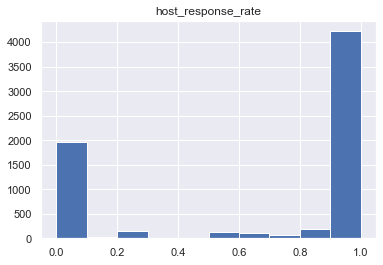

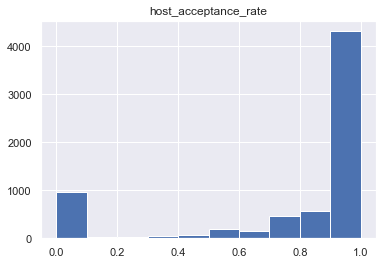

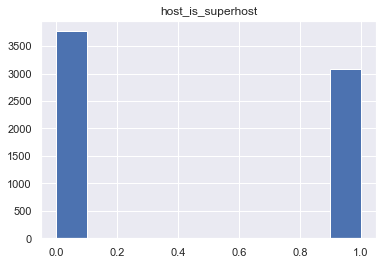

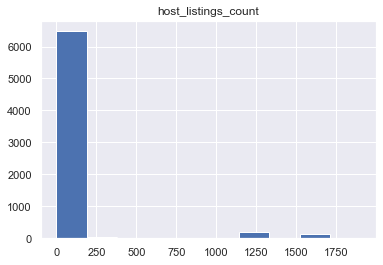

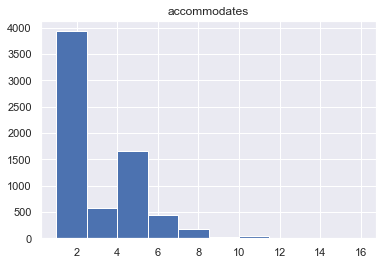

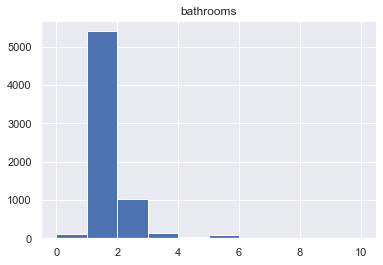

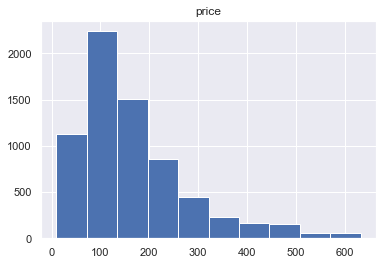

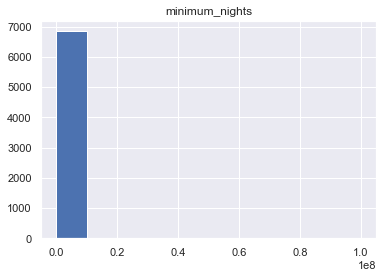

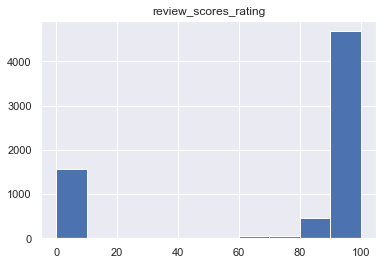

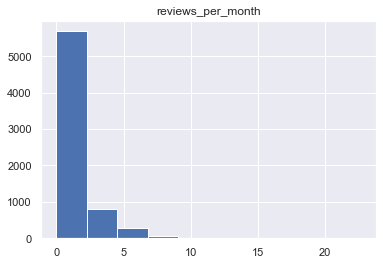

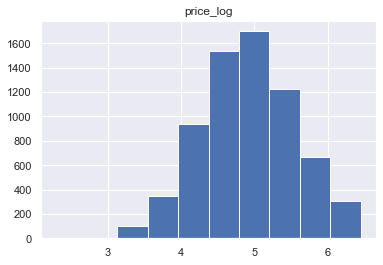

In [225]:
new_numeric_cols = []
for col in new_SF_df.columns: 
    if col in numeric_columns:
        new_numeric_cols.append(col)
        try:      
            new_SF_df[col] = pd.to_numeric(new_SF_df[col]) 
            new_SF_df.hist(column=col)
        except ValueError:
            print('This column can not be represented as a histogram')

# LassoCV Model

In [227]:
from sklearn.linear_model import Lasso, LassoCV

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [228]:
# R2 of Training set
lasso_model.score(X_train,y_train)

# Predict model on test data
y_pred = lasso_model.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 16899.826
RMSE test: 677278.962
R^2 test: -39153734.823


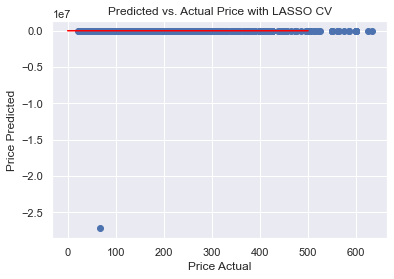

In [229]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with LASSO CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual');

# RidgeCV Model

In [230]:
from sklearn.linear_model import RidgeCV

reg_params = 10.**np.linspace(-10, 5, 10)
ridge_model = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
ridge_model.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.32292e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.33149e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.73059e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.67815e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.39554e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_r

RidgeCV(alphas=array([1.00000000e-10, 4.64158883e-09, 2.15443469e-07, 1.00000000e-05,
       4.64158883e-04, 2.15443469e-02, 1.00000000e+00, 4.64158883e+01,
       2.15443469e+03, 1.00000000e+05]),
        cv=5)

In [231]:
# R2 of Training set
ridge_model.score(X_train,y_train)

# Predict model on test data
y_pred = ridge_model.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 16782.241
RMSE test: 672525.950
R^2 test: -38606116.441


Text(0.5, 0, 'Price Actual')

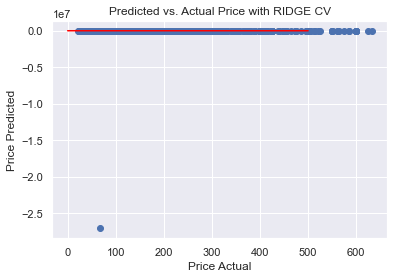

In [232]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with RIDGE CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual')

# Removing Problematic rows and redo LassoCV, RidgeCV and NN

## Finding and Removing Problematic rows

In [233]:
result_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})

In [234]:
result_df.sort_values(by='Predicted')

,Actual,Predicted
2357,68.00,-2.704350e+07
5353,50.14,-5.732203e+01
5354,46.00,-5.554962e+01
5900,37.00,-2.721705e+01
5602,39.00,-2.655340e+01
...,...,...
2433,359.00,4.445432e+02
1163,350.00,4.538369e+02
2379,500.00,4.539069e+02
6426,250.00,4.616286e+02


In [235]:
problem_row = listings_new[(listings_new['price_log'] >= 4.21) & (listings_new['price_log'] < 4.22)]
problem_row[['price','price_log']].shape
listings_new.shape

(6465, 225)

In [236]:
new_non_problematic_df = listings_new[listings_new['price'] != 68]
new_non_problematic_df[new_non_problematic_df['price']!=68]

,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,accommodates,bathrooms,price,minimum_nights,review_scores_rating,reviews_per_month,...,table corner guards,terrace,tv,walk in closet,washer,waterfront,wet bar,wifi,window guards,wine cooler
0,1.0,0.99,1,1,3,1.0,132.00,2,97.0,1.91,...,0,0,1,0,1,0,0,1,0,0
1,0.6,0.83,0,2,5,1.0,235.00,30,98.0,0.81,...,0,0,0,0,1,0,0,1,0,0
2,1.0,1.00,0,10,2,4.0,56.00,32,84.0,0.14,...,0,0,1,0,1,0,0,1,0,0
3,1.0,1.00,0,10,2,4.0,56.00,32,93.0,0.11,...,0,0,1,0,1,0,0,1,0,0
5,1.0,0.96,1,2,3,1.0,169.00,1,98.0,5.47,...,0,0,1,0,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6843,1.0,1.00,0,0,1,2.0,43.57,30,0.0,0.00,...,0,0,0,0,1,0,0,1,0,0
6844,1.0,1.00,0,0,1,2.0,63.00,30,0.0,0.00,...,0,0,1,0,1,0,0,1,0,0
6845,1.0,1.00,0,0,1,2.0,51.00,30,0.0,0.00,...,0,0,1,0,1,0,0,1,0,0
6846,1.0,1.00,0,0,1,3.5,58.00,30,0.0,0.00,...,0,0,1,0,1,0,0,1,0,0


## Reassign to new train/test data

In [237]:
y = new_non_problematic_df['price'] # target/dependent variable
x = new_non_problematic_df.drop(['price','price_log'], axis =1) # independent variables

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.25, random_state=1)

## LassoCV

In [238]:
from sklearn.linear_model import Lasso, LassoCV

# Run the cross validation, find the best alpha, refit the model on all the data with that alpha
alphavec = 10**np.linspace(-2,2,200)
lasso_model = LassoCV(alphas = alphavec, cv=5)
lasso_model.fit(X_train, y_train)

LassoCV(alphas=array([1.00000000e-02, 1.04737090e-02, 1.09698580e-02, 1.14895100e-02,
       1.20337784e-02, 1.26038293e-02, 1.32008840e-02, 1.38262217e-02,
       1.44811823e-02, 1.51671689e-02, 1.58856513e-02, 1.66381689e-02,
       1.74263339e-02, 1.82518349e-02, 1.91164408e-02, 2.00220037e-02,
       2.09704640e-02, 2.19638537e-02, 2.30043012e-02, 2.40940356e-02,
       2.52353917e-02, 2.64308149e-0...
       3.44896226e+01, 3.61234270e+01, 3.78346262e+01, 3.96268864e+01,
       4.15040476e+01, 4.34701316e+01, 4.55293507e+01, 4.76861170e+01,
       4.99450512e+01, 5.23109931e+01, 5.47890118e+01, 5.73844165e+01,
       6.01027678e+01, 6.29498899e+01, 6.59318827e+01, 6.90551352e+01,
       7.23263390e+01, 7.57525026e+01, 7.93409667e+01, 8.30994195e+01,
       8.70359136e+01, 9.11588830e+01, 9.54771611e+01, 1.00000000e+02]),
        cv=5)

In [239]:
# R2 of Training set
lasso_model.score(X_train,y_train)

# Predict model on test data
y_pred = lasso_model.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 57.855
RMSE test: 83.233
R^2 test: 0.454


Text(0.5, 0, 'Price Actual')

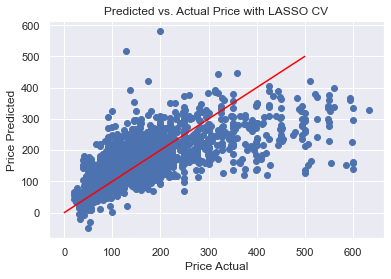

In [240]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with LASSO CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual')

## RidgeCV

In [241]:
from sklearn.linear_model import RidgeCV

reg_params = 10.**np.linspace(-10, 5, 10)
ridge_model = RidgeCV(alphas=reg_params, fit_intercept=True, cv=5)
ridge_model.fit(X_train, y_train)

C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.29315e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30502e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.01913e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.30336e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=1.38403e-19): result may not be accurate.
  overwrite_a=True).T
C:\Users\User\Anaconda3\lib\site-packages\sklearn\linear_model\_r

RidgeCV(alphas=array([1.00000000e-10, 4.64158883e-09, 2.15443469e-07, 1.00000000e-05,
       4.64158883e-04, 2.15443469e-02, 1.00000000e+00, 4.64158883e+01,
       2.15443469e+03, 1.00000000e+05]),
        cv=5)

In [242]:
# R2 of Training set
ridge_model.score(X_train,y_train)

# Predict model on test data
y_pred = ridge_model.predict(X_test)

#Mean Absolute Error (MAE)
def mae(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true))
print('MAE: %.3f' % mae(y_test, y_pred))

rmse_rf= (mean_squared_error(y_test,y_pred))**(1/2)

print('RMSE test: %.3f' % rmse_rf)
print('R^2 test: %.3f' % (r2_score(y_test, y_pred)))

MAE: 58.733
RMSE test: 83.796
R^2 test: 0.447


Text(0.5, 0, 'Price Actual')

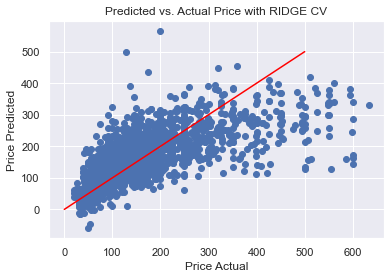

In [243]:
plt.scatter(y_test, y_pred)
plt.plot([0,500],[0,500],color='red')
plt.grid(True)
plt.title('Predicted vs. Actual Price with RIDGE CV')
plt.ylabel('Price Predicted')
plt.xlabel('Price Actual')

## Neural Network

In [244]:
from keras import models, layers, optimizers, regularizers
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG

# Building the model
nn2 = models.Sequential()
nn2.add(layers.Dense(128, input_shape=(X_train.shape[1],), activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(256, activation='relu'))
nn2.add(layers.Dense(512, activation='relu'))
nn2.add(layers.Dense(1, activation='linear'))

# Compiling the model
nn2.compile(loss='mean_squared_error',
            optimizer='adam',
            metrics=['mean_squared_error'])

# Printing the model summary
print(nn2.summary())

# Visualising the neural network
SVG(model_to_dot(nn2, show_layer_names=False, show_shapes=True).create(prog='dot', format='svg'))

# Training the model
nn2_history = nn2.fit(X_train,
                  y_train,
                  epochs=100,
                  batch_size=256,
                  validation_split = 0.1)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 128)               28672     
_________________________________________________________________
dense_26 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_27 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_28 (Dense)             (None, 512)               131584    
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 513       
Total params: 259,585
Trainable params: 259,585
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
17/17 [==============================] - 0s 23ms/step - loss: 25716.4258 - mean_squared_error: 25

Epoch 42/100
17/17 [==============================] - 0s 12ms/step - loss: 4016.7954 - mean_squared_error: 4016.7954 - val_loss: 6754.5166 - val_mean_squared_error: 6754.5166
Epoch 43/100
17/17 [==============================] - 0s 12ms/step - loss: 4010.8811 - mean_squared_error: 4010.8811 - val_loss: 5560.3828 - val_mean_squared_error: 5560.3828
Epoch 44/100
17/17 [==============================] - 0s 15ms/step - loss: 3932.6470 - mean_squared_error: 3932.6470 - val_loss: 5598.6226 - val_mean_squared_error: 5598.6226
Epoch 45/100
17/17 [==============================] - 0s 11ms/step - loss: 3936.2688 - mean_squared_error: 3936.2688 - val_loss: 5900.0674 - val_mean_squared_error: 5900.0674
Epoch 46/100
17/17 [==============================] - 0s 11ms/step - loss: 3831.5869 - mean_squared_error: 3831.5869 - val_loss: 5769.8149 - val_mean_squared_error: 5769.8149
Epoch 47/100
17/17 [==============================] - 0s 12ms/step - loss: 4224.6782 - mean_squared_error: 4224.6782 - val_lo

In [245]:
y_test_pred = nn2.predict(X_test)
y_train_pred = nn2.predict(X_train)
print("Training MSE:", round(mean_squared_error(y_train, y_train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_test, y_test_pred),4))
print("Validation RMSE:", round(mean_squared_error(y_test, y_test_pred)**0.5,4))
print("\nTraining r2:", round(r2_score(y_train, y_train_pred),4))
print("Validation r2:", round(r2_score(y_test, y_test_pred),4))

Training MSE: 2927.8128
Validation MSE: 7321.5182
Validation RMSE: 85.5659

Training r2: 0.7673
Validation r2: 0.4234
